In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

BATCH_SIZE = 64

In [3]:
train_dataset = torchvision.datasets.MNIST('./data' , transform=transform, download=False)
test_dataset = torchvision.datasets.MNIST('./data' , transform=transform, download=False, train=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

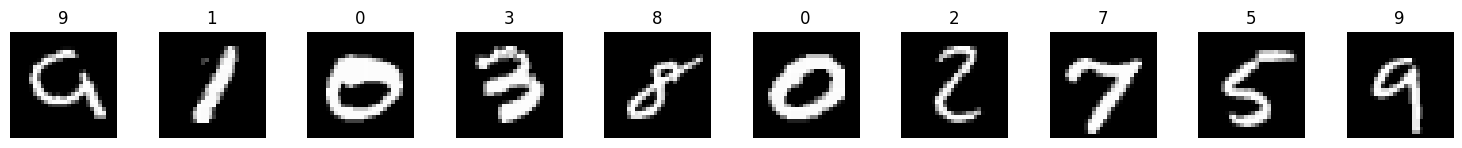

In [4]:
data_iter = iter(train_loader) # convertirlo en iterable
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(str(labels[i].item()))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = self.get_encoder()
        
        self.fc_mu = torch.nn.Linear(64, 64)
        self.fc_logvar = torch.nn.Linear(64, 64)

        self.decoder = self.get_decoder()

    def get_decoder(self):
        dec = torch.nn.Sequential(
            # 64,1,1
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7), # 32, 7, ,7
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # 16, 14, 14
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), # 1, 28, 28
            torch.nn.Sigmoid()
        )
        return dec

    def get_encoder(self):
        enc = torch.nn.Sequential(
            # 1,28,28
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # 16,14,14
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1 ), # 32,7,7
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # 64, 1, 1
            torch.nn.ReLU(),

            torch.nn.Flatten() # 64 latent space dimensions
        )

        return enc 

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # std = e^(logvar*0.5)
        sigma = torch.exp(0.5*logvar)
        # z = mean + std * epsilon (n(0,1))
        z = mu + sigma * torch.randn_like(sigma)

        z = z.view(z.size(0), z.size(1), 1, 1) #64,64,1,1
        x_recap = self.decoder(z)

        return x_recap, mu, logvar

In [6]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

EPOCHS = 5

In [7]:
for t in range(EPOCHS):
    model.train()
    running_loss = 0.0
    print("epoch "+str(t))
    for idx, (images, label) in enumerate(train_loader):
        x_recap, mu, logvar = model(images)

        # calculate loss --> reconstruction loss + regularization loss
        reconstruction_loss = torch.nn.functional.mse_loss(x_recap, images, reduction='sum')
        regularization_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # kl div
        loss = reconstruction_loss + regularization_loss

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        print(str((idx*100) / len(train_loader)) + '%')

epoch 0
0.0%
0.10660980810234541%
0.21321961620469082%
0.31982942430703626%
0.42643923240938164%
0.5330490405117271%
0.6396588486140725%
0.746268656716418%
0.8528784648187633%
0.9594882729211087%
1.0660980810234542%
1.1727078891257996%
1.279317697228145%
1.3859275053304905%
1.492537313432836%
1.5991471215351811%
1.7057569296375266%
1.812366737739872%
1.9189765458422174%
2.025586353944563%
2.1321961620469083%
2.2388059701492535%
2.345415778251599%
2.4520255863539444%
2.55863539445629%
2.6652452025586353%
2.771855010660981%
2.878464818763326%
2.985074626865672%
3.091684434968017%
3.1982942430703623%
3.304904051172708%
3.411513859275053%
3.518123667377399%
3.624733475479744%
3.7313432835820897%
3.837953091684435%
3.9445628997867805%
4.051172707889126%
4.157782515991471%
4.264392324093817%
4.371002132196162%
4.477611940298507%
4.584221748400853%
4.690831556503198%
4.797441364605544%
4.904051172707889%
5.0106609808102345%
5.11727078891258%
5.223880597014926%
5.330490405117271%
5.43710021321

In [8]:
mu = torch.zeros(10,64) # 10 images
logvar = torch.ones(10,64)
sigma = torch.exp(0.5*logvar)
z = mu + sigma * torch.randn_like(sigma)
z = z.view(z.size(0),z.size(1),1,1)
x_recon = model.decoder(z)

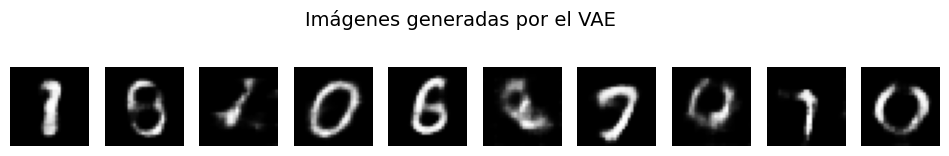

In [9]:
images = x_recon.cpu().detach().squeeze().numpy()  # (10, 28, 28)

plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Imágenes generadas por el VAE", fontsize=14)
plt.show()